# DEPENDÊNCIAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree

# FUNÇÕES

In [2]:
def df_head(df: pd.DataFrame, n: int = 5):
    display(df.head(n))
    print(f"Shape: {df.shape}")

def cross_val(model, X, y, n_splits=5, metric="r2", shuffle=True, random_state=None):
    """
    Realiza validação cruzada com K-Fold para treinar e avaliar um modelo,
    utilizando uma métrica especificada para avaliar o desempenho em cada fold.
    O modelo é clonado e treinado novamente a cada divisão dos dados.

    Args:
        model (sklearn.base.BaseEstimator): Modelo que implementa os métodos `fit` e `predict`.
        X (pandas.DataFrame): Conjunto de dados de entrada (features).
        y (pandas.Series): Vetor alvo (target) correspondente às amostras em `X`.
        n_splits (int, optional): Número de folds da validação cruzada. Default é 5.
        metric (str, optional): Métrica de avaliação a ser utilizada.
            Opções válidas: "r2", "mse", "mae". Caso a métrica seja inválida, será usada a default: "r2".
        shuffle (bool, optional): Se True, embaralha os dados antes de dividir em folds. Default é True.
        random_state (int or None, optional): Semente usada para o embaralhamento. Default é None (comportamento randômico).

    Returns:
        tuple:
            models (list): Lista de modelos treinados, um para cada fold.
            metrics (list): Lista de valores da métrica de avaliação para cada fold.

    Note:
        Se uma métrica inválida for fornecida, a função utilizará "r2" como padrão, sem gerar erro.
    """
    DICT_METRICS = {
        "r2":   r2_score,
        "mse":  mean_squared_error,
        "mae":  mean_absolute_error
    }
    models = list()
    metrics = list()
    metric_to_use = DICT_METRICS.get(metric, r2_score)

    # Define os índices que delimitam as partições
    kfolds = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    for i, (train_index, test_index) in enumerate(kfolds.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        copy = clone(model)
        copy.fit(X_train, y_train)

        models.append(copy)
        metrics.append(metric_to_use(y_test, copy.predict(X_test))) # Calcula métrica

    return models, metrics

# SETUP DO AMBIENTE

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


# OBTENÇÃO DO DATASET

In [4]:
#PATH = "/content/drive/MyDrive/07_per_shared/projCDat_25_1/datasets/cooked/_all/all_merged.csv"
PATH = "/content/drive/MyDrive/projCDat_25_1/datasets/cooked/_all/all_merged.csv"

df = pd.read_csv(PATH)
df_head(df)

,_ano,_estado,_mes,car_c02_emitido,cli_pressao_atm_med,cli_temp_ar_med,cli_temp_orvalho_med,cli_umid_rel_med,cli_umid_rel_min_max,cli_umid_rel_min_med,cli_umid_rel_min_min,cli_veloc_vento_max,cli_veloc_vento_med,que_area_queimada,que_focos_qtd
0,2008,AC,7,2.627698e+07,986.843612,28.142731,18.914978,59.555066,95.0,54.432558,29.0,5.1,2.152915,4957.0,165.0
1,2008,AC,9,2.627698e+07,991.705941,24.446194,19.467987,75.811881,97.0,72.496700,25.0,1.0,0.210504,46073.0,2947.0
2,2008,AC,10,2.627698e+07,990.328360,25.229298,21.617473,81.870968,96.0,78.720430,29.0,1.0,0.204959,30355.0,856.0
3,2008,AC,11,2.627698e+07,988.610987,25.195410,22.624478,86.905424,96.0,84.048679,42.0,1.0,0.186970,2082.0,63.0
4,2008,AC,12,2.627698e+07,988.692608,24.898790,22.727554,88.529570,96.0,86.116935,53.0,1.0,0.179442,127.0,4.0


Shape: (1025, 15)


# CODIFICAÇÃO


In [5]:
# Codificação OneHot simplificada
TO_ENCODE = ["_estado"]
df_encoded = pd.get_dummies(df, columns=TO_ENCODE, dtype="Int32")

df_head(df_encoded)

,_ano,_mes,car_c02_emitido,cli_pressao_atm_med,cli_temp_ar_med,cli_temp_orvalho_med,cli_umid_rel_med,cli_umid_rel_min_max,cli_umid_rel_min_med,cli_umid_rel_min_min,...,cli_veloc_vento_med,que_area_queimada,que_focos_qtd,_estado_AC,_estado_AM,_estado_AP,_estado_PA,_estado_RO,_estado_RR,_estado_TO
0,2008,7,2.627698e+07,986.843612,28.142731,18.914978,59.555066,95.0,54.432558,29.0,...,2.152915,4957.0,165.0,1,0,0,0,0,0,0
1,2008,9,2.627698e+07,991.705941,24.446194,19.467987,75.811881,97.0,72.496700,25.0,...,0.210504,46073.0,2947.0,1,0,0,0,0,0,0
2,2008,10,2.627698e+07,990.328360,25.229298,21.617473,81.870968,96.0,78.720430,29.0,...,0.204959,30355.0,856.0,1,0,0,0,0,0,0
3,2008,11,2.627698e+07,988.610987,25.195410,22.624478,86.905424,96.0,84.048679,42.0,...,0.186970,2082.0,63.0,1,0,0,0,0,0,0
4,2008,12,2.627698e+07,988.692608,24.898790,22.727554,88.529570,96.0,86.116935,53.0,...,0.179442,127.0,4.0,1,0,0,0,0,0,0


Shape: (1025, 21)


# NORMALIZAÇÃO

In [6]:
NORMALIZE = False
RANGE = (0.0, 1.0)

scaler = MinMaxScaler(feature_range=RANGE)
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns) if NORMALIZE else df_encoded

df_head(df_scaled)

,_ano,_mes,car_c02_emitido,cli_pressao_atm_med,cli_temp_ar_med,cli_temp_orvalho_med,cli_umid_rel_med,cli_umid_rel_min_max,cli_umid_rel_min_med,cli_umid_rel_min_min,...,cli_veloc_vento_med,que_area_queimada,que_focos_qtd,_estado_AC,_estado_AM,_estado_AP,_estado_PA,_estado_RO,_estado_RR,_estado_TO
0,2008,7,2.627698e+07,986.843612,28.142731,18.914978,59.555066,95.0,54.432558,29.0,...,2.152915,4957.0,165.0,1,0,0,0,0,0,0
1,2008,9,2.627698e+07,991.705941,24.446194,19.467987,75.811881,97.0,72.496700,25.0,...,0.210504,46073.0,2947.0,1,0,0,0,0,0,0
2,2008,10,2.627698e+07,990.328360,25.229298,21.617473,81.870968,96.0,78.720430,29.0,...,0.204959,30355.0,856.0,1,0,0,0,0,0,0
3,2008,11,2.627698e+07,988.610987,25.195410,22.624478,86.905424,96.0,84.048679,42.0,...,0.186970,2082.0,63.0,1,0,0,0,0,0,0
4,2008,12,2.627698e+07,988.692608,24.898790,22.727554,88.529570,96.0,86.116935,53.0,...,0.179442,127.0,4.0,1,0,0,0,0,0,0


Shape: (1025, 21)


# PARTIÇÃO DO *DATASET*

In [7]:
TARGET = "car_c02_emitido" # Mude caso desejar
RANDOM_STATE = 42            # Fixa semente aleatória
TRAIN_SIZE = 0.70

X = df_scaled.drop(columns=TARGET)  # Preditores
y = df_scaled[TARGET]               # Variável alvo

# Particiona dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, train_size=TRAIN_SIZE)

df_head(X_train)
df_head(y_train)

,_ano,_mes,cli_pressao_atm_med,cli_temp_ar_med,cli_temp_orvalho_med,cli_umid_rel_med,cli_umid_rel_min_max,cli_umid_rel_min_med,cli_umid_rel_min_min,cli_veloc_vento_max,cli_veloc_vento_med,que_area_queimada,que_focos_qtd,_estado_AC,_estado_AM,_estado_AP,_estado_PA,_estado_RO,_estado_RR,_estado_TO
1020,2023,8,981.811559,28.596371,14.201750,45.434140,83.0,42.395161,16.0,5.0,1.562108,390184.0,1388.0,0,0,0,0,0,0,1
479,2014,8,983.526210,26.247390,20.965469,73.346479,94.0,69.720445,34.0,2.0,0.506474,346709.0,1263.0,0,0,0,1,0,0,0
227,2015,9,1007.279028,29.660972,22.760062,67.894444,95.0,64.906944,29.0,1.7,0.246516,233589.0,2949.0,0,1,0,0,0,0,0
910,2013,7,982.035801,25.619650,12.744818,50.429341,86.0,46.963661,14.0,4.5,1.342935,194409.0,98.0,0,0,0,0,0,0,1
362,2015,10,1010.336290,26.872527,22.301210,78.152113,93.0,75.381793,45.0,2.8,1.087854,191660.0,912.0,0,0,1,0,0,0,0


Shape: (717, 20)


,car_c02_emitido
1020,8.870288e+07
479,2.608387e+08
227,7.872848e+07
910,6.569935e+07
362,3.958983e+06


Shape: (717,)


# MODELO

Será adotada uma árvore de regressão, por sua interpretabilidade e por sua relativa simplicidade se comparada a outros modelos. No caso da biblioteca `sklearn`, a árvore demanda dados numéricos, o que explica a codificação realizada acima. A normalização foi feita a fim de tornar as medidas de erro menores em módulo.

In [8]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE) # Mude caso desejar

# MODELO E VALIDAÇÃO CRUZADA

Para maior confiabilidade na escolha do melhor modelo, adotou-se uma validação cruzada baseada em $K$ _folds_, com $K = 5$. Consiste na partição do _dataset_ $D_T$ de treino em $K$ partições $P_i$, com $i = 1, \dots, K$, de modo que

1) $i \neq j \Rightarrow P_i \cap P_j = \emptyset$
<br><br>
2) $ \bigcup_{i = 1}^K \ {P_i} \ = D_T$

<br>
Assim, realizam-se $K$ iterações, em que cada qual utiliza uma $P_i$ diferente para validação (teste interno) e treina com as demais $P_j, i \neq j$. Dessa forma, o desempenho geral do modelo é calculado pela média das métricas das iterações, sendo escolhida a versão treinada com as partições que tenham produzido os resultados mais ótimos segundo dado critério.

In [9]:
FOLD_NUM = 5 # Número de partições (K)
DICT_METRIC_NAME = {
    "r2":  "Coeficiente de Determinação",
    "mse": "Erro Quadrático Médio",
    "mae": "Erro Absoluto Médio",
}

for metric, name in DICT_METRIC_NAME.items():
    models, scores = cross_val(model, X_train, y_train, n_splits=FOLD_NUM, metric=metric, shuffle=True, random_state=RANDOM_STATE)

    print(f"{name}: {np.mean(scores)}") # Computa média das métricas das iterações
    for i, score in enumerate(scores):
        print(f"Fold {i}: {score}")     # Métrica na iteração em que o Fold i serviu de validação
    print("")

Coeficiente de Determinação: 0.9898526950655284
Fold 0: 0.9759015584645911
Fold 1: 0.9990734586525641
Fold 2: 0.9980023973087309
Fold 3: 0.9952573054332776
Fold 4: 0.9810287554684783

Erro Quadrático Médio: 184512947426747.8
Fold 0: 527535711972796.44
Fold 1: 10431920640746.988
Fold 2: 31826040605344.336
Fold 3: 103263250039995.77
Fold 4: 249507813874855.5

Erro Absoluto Médio: 2500712.213191892
Fold 0: 5116202.169399955
Fold 1: 970150.0035305776
Fold 2: 996711.3369127304
Fold 3: 2411563.368359767
Fold 4: 3008934.187756429



# VARIÂNCIA

In [10]:
VAR_Y = y_test.var()
print(f"Variância da variável alvo do conjunto de teste: {VAR_Y}")

Variância da variável alvo do conjunto de teste: 2.028790192063824e+16


# TESTE

Foi adotado o modelo que tenha maximizado o Coeficiente de Determinação $R^2$ (`"r2"`), por ser uma métrica facilmente interpretável:

- $R^2 = 1$: modelo perfeito;
- $0 < R^2 < 1$: melhor que predizer sempre a média, mas não perfeito.
- $R^2 = 0$: equivalente a predizer sempre a média;
- $R^2 < 0$: pior que predizer sempre a média.

<br>
Quanto às demais, por serem baseadas na noção direta de distância, seria mais difícil determinar a partir de qual faixa de erro o modelo poderia ser considerado satisfatório.

A seguir, realizam-se as predições de teste (externo).

In [11]:
BEST_IDX = 1
BEST_MODEL = models[BEST_IDX]
DICT_METRIC_FUNCTION = {
    "r2":  r2_score,
    "mse": mean_squared_error,
    "mae": mean_absolute_error,
}
dict_metrics_result = dict()

y_pred = BEST_MODEL.predict(X_test)

for metric, function in DICT_METRIC_FUNCTION.items():
    dict_metrics_result[metric] = function(y_test, y_pred)
    print(f"{DICT_METRIC_NAME[metric]}: {dict_metrics_result[metric]}")

Coeficiente de Determinação: 0.9984396714545657
Erro Quadrático Médio: 31553013946686.305
Erro Absoluto Médio: 1285648.177275233


# ANÁLISE GRÁFICA

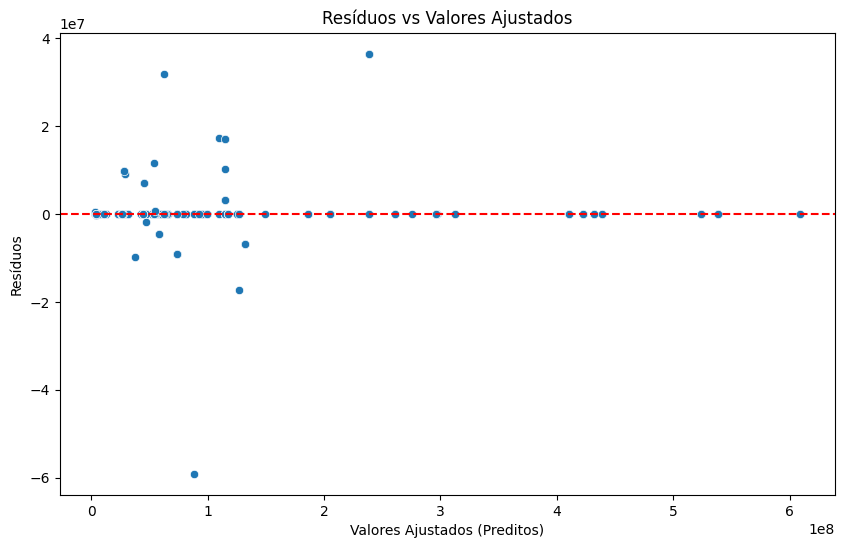

In [12]:
residuals = y_test - y_pred

# Gera gráfico de dispersão de resíduos vs valores ajustados
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color="r", linestyle="--") # Adiciona linha horizontal em y=0
plt.xlabel("Valores Ajustados (Preditos)")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Valores Ajustados")
plt.show()

# CONCLUSÃO

As métricas de erro mostraram-se ótimas em demasia, o que aponta para a baixa heterogeneidade do _dataset_, ocasionada pela imputação das emissões anuais de CO₂ para comporem os valores mensais (a variável alvo). Nesse sentido, na última _sprint_, deve-se coletar os dados mensais, a fim de possibilitar melhor generalização pelo modelo.

# CENÁRIO SEM CO₂

In [13]:
# TREINAMENTO
CARB = "car_c02_emitido"
df_carbless = df_scaled.drop(columns=CARB)
TARGET_LESS = "que_area_queimada"

y_less = df_carbless[TARGET_LESS]
X_less = df_carbless.drop(columns=TARGET_LESS)

X_train_less, X_test_less, y_train_less, y_test_less = train_test_split(X_less, y_less, random_state=RANDOM_STATE, train_size=TRAIN_SIZE)

# MODELO
model_less = DecisionTreeRegressor(random_state=RANDOM_STATE)

# AVALIAÇÃO
for metric, name in DICT_METRIC_NAME.items():
    models, scores = cross_val(model_less, X_train, y_train, n_splits=FOLD_NUM, metric=metric, shuffle=True, random_state=RANDOM_STATE)

    print(f"{name}: {np.mean(scores)}") # Computa média das métricas das iterações
    for i, score in enumerate(scores):
        print(f"Fold {i}: {score}")     # Métrica na iteração em que o Fold i serviu de validação
    print("")

Coeficiente de Determinação: 0.9898526950655284
Fold 0: 0.9759015584645911
Fold 1: 0.9990734586525641
Fold 2: 0.9980023973087309
Fold 3: 0.9952573054332776
Fold 4: 0.9810287554684783

Erro Quadrático Médio: 184512947426747.8
Fold 0: 527535711972796.44
Fold 1: 10431920640746.988
Fold 2: 31826040605344.336
Fold 3: 103263250039995.77
Fold 4: 249507813874855.5

Erro Absoluto Médio: 2500712.213191892
Fold 0: 5116202.169399955
Fold 1: 970150.0035305776
Fold 2: 996711.3369127304
Fold 3: 2411563.368359767
Fold 4: 3008934.187756429



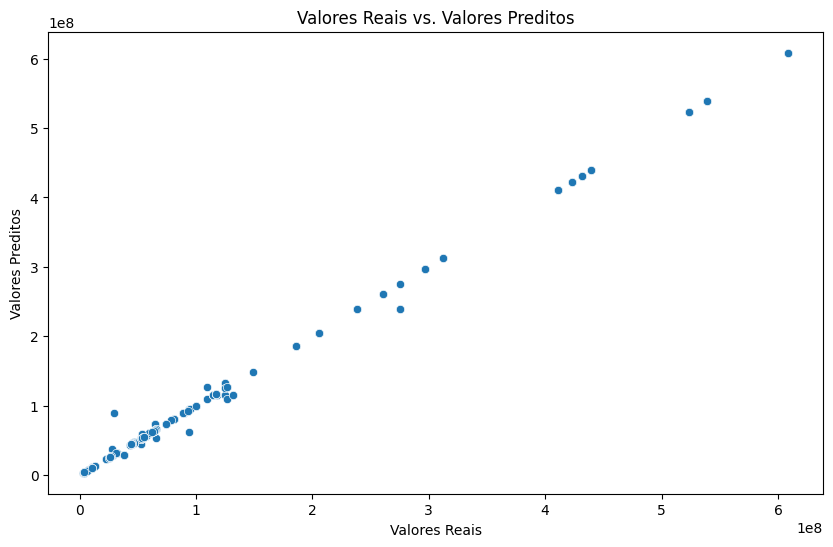

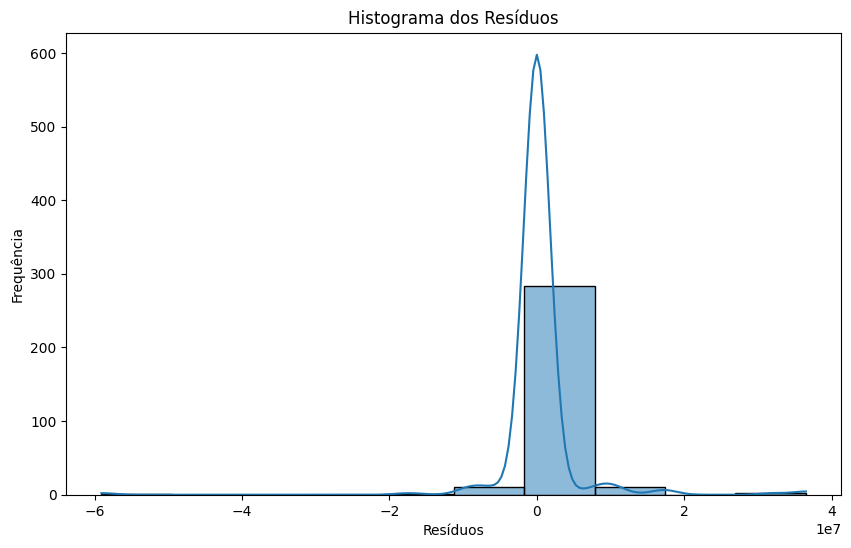

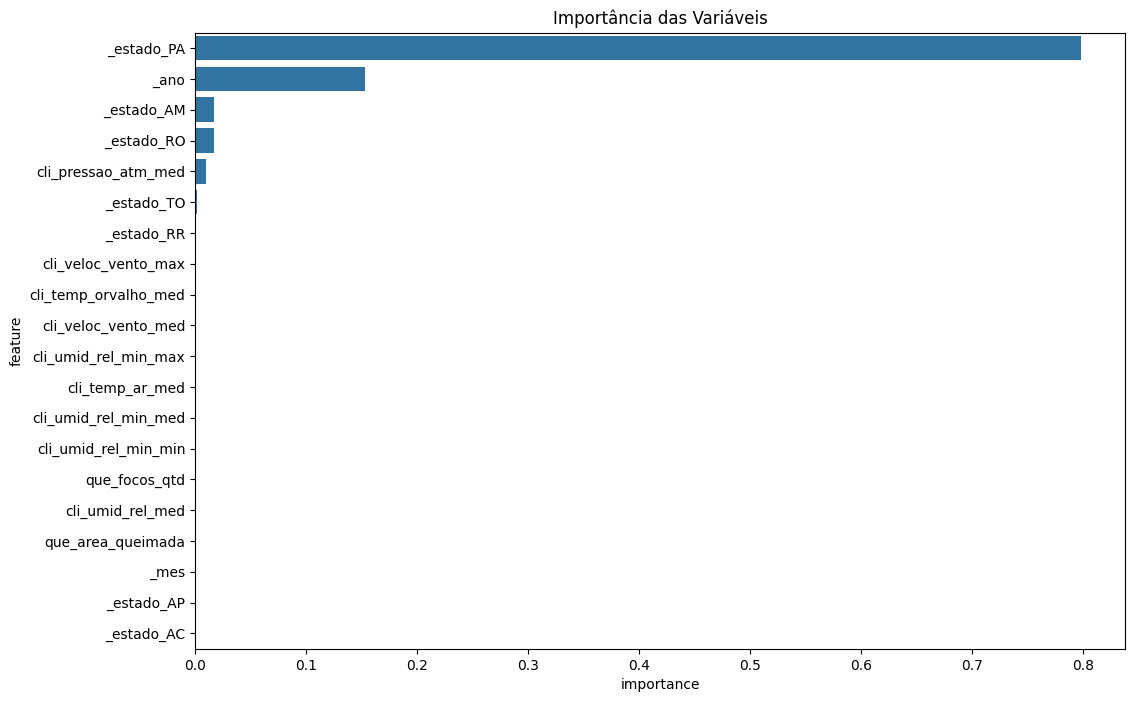

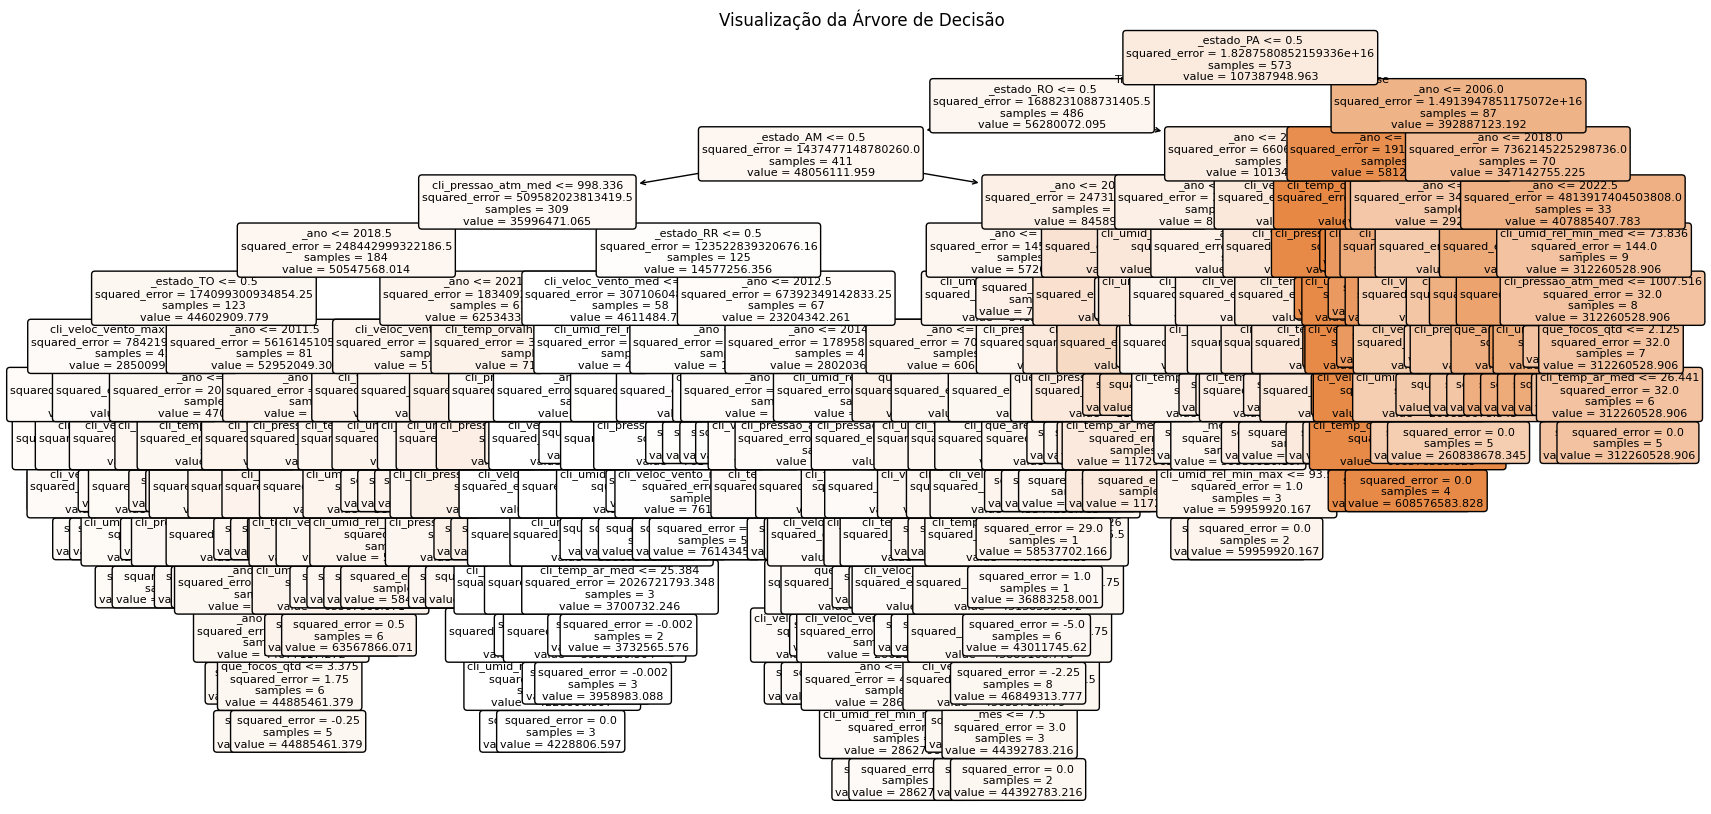

In [14]:
# Gráfico de Dispersão: Real vs. Previsto
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Valores Reais vs. Valores Preditos")
plt.show()

# Histograma dos Resíduos
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.title("Histograma dos Resíduos")
plt.show()

# Gráfico de Importância das Variáveis (Feature Importance)
importance = BEST_MODEL.feature_importances_
feature_names = X_test.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importância das Variáveis')
plt.show()

# Visualização da Árvore de Decisão (para árvores menores)
"""
Para árvores grandes, esta visualização pode ser muito densa.
É recomendável usar bibliotecas como graphviz para visualizações mais detalhadas.
"""
plt.figure(figsize=(20, 10))
plot_tree(BEST_MODEL, feature_names=feature_names, filled=True, rounded=True, fontsize=8)
plt.title("Visualização da Árvore de Decisão")
plt.show()

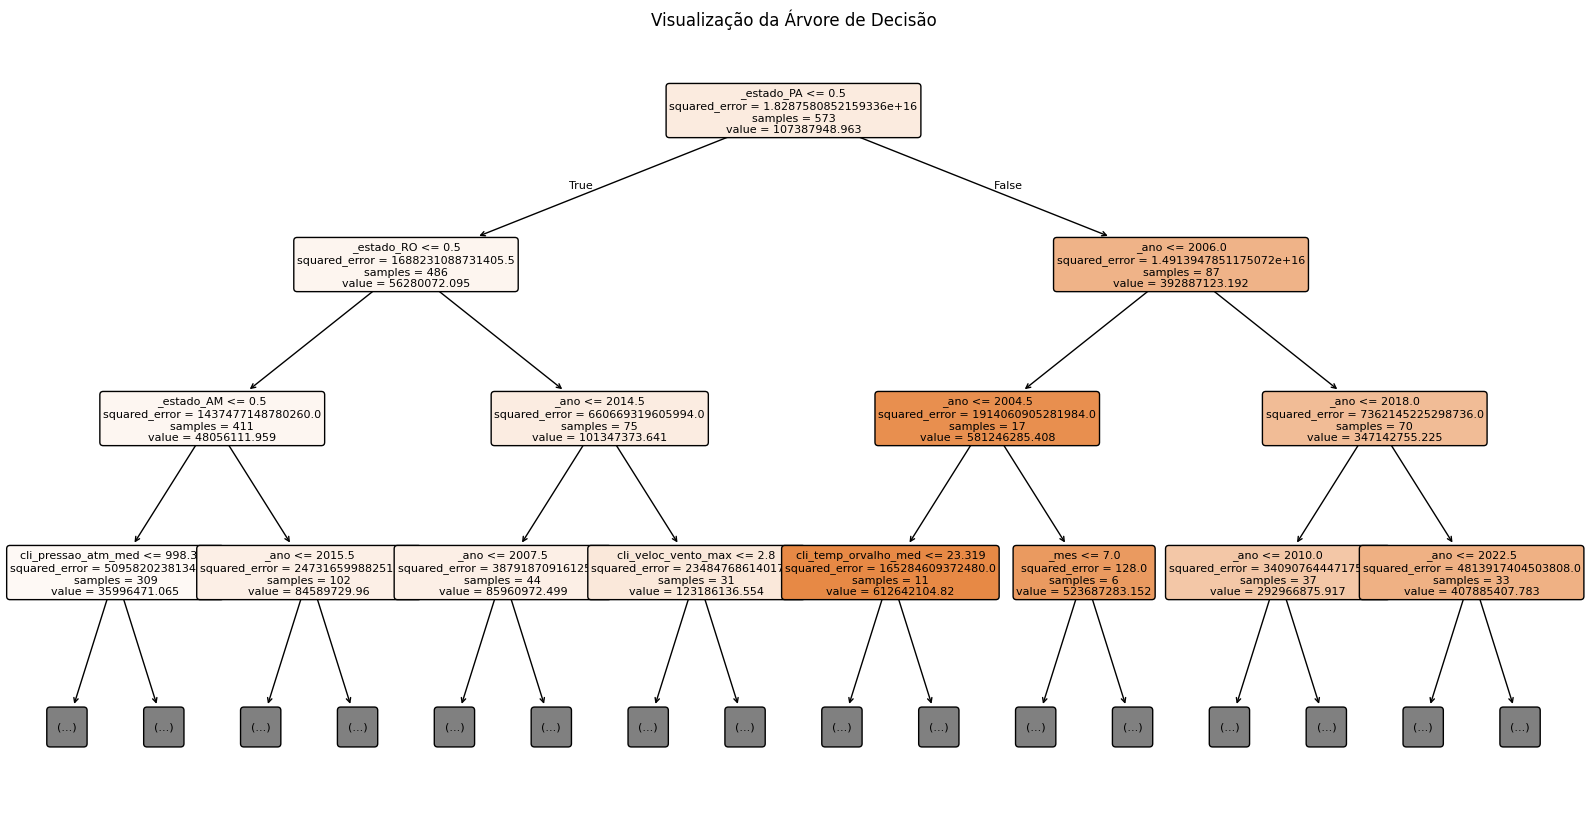

In [15]:
plt.figure(figsize=(20, 10))
plot_tree(BEST_MODEL, feature_names=feature_names, filled=True, rounded=True, fontsize=8, max_depth=3)
plt.title("Visualização da Árvore de Decisão")
plt.show()